# Chapter 3: Classification models
This chapter aims to show one classification model defined in Pytorch from scratches.

In [1]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

path_pardir = Path(os.getcwd()).parent
path_data = os.path.join(path_pardir, 'Data')

# S3-1: Classification model
We want to introduce an elementary classification model on the provided dataset.

First we define the device:

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


Read the existing database and subdivide it in training/validation/test:

In [3]:
chosen_df = "df_classification.csv"

full_df = pd.read_csv(os.path.join(path_data, chosen_df))

training_df = full_df[full_df["split_label"]==0]
validation_df = full_df[full_df["split_label"]==1]
test_df = full_df[full_df["split_label"]==2]

print("Dataframe length:", len(full_df))
print("Training length:", len(training_df))
print("Validation length:", len(validation_df))
print("Test length:", len(test_df))

full_df.head(8)

Dataframe length: 2100
Training length: 1600
Validation length: 200
Test length: 300


,x_range,y_range,split_label,label
0,-100.00000,-0.942655,0,0
1,-99.89995,-3.823028,0,1
2,-99.79990,-2.846601,2,1
3,-99.69985,-1.737359,2,0
4,-99.59980,-2.570040,0,1
5,-99.49975,-0.153353,1,0
6,-99.39970,-0.654207,0,0
7,-99.29965,-1.954208,0,1


Show the scatterplots of the training and test dataframe:

<Axes: xlabel='x_range', ylabel='y_range'>

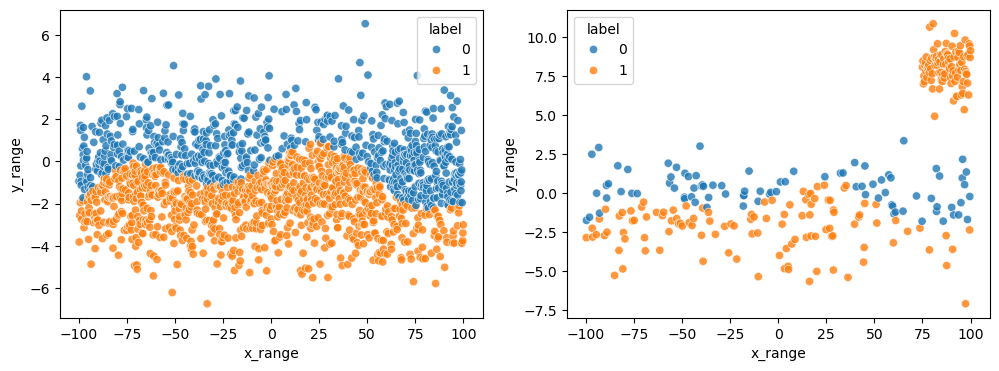

In [4]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

# Scatter plot
sns.scatterplot(data=training_df, x="x_range", y="y_range", hue="label", alpha = 0.8, ax = axs[0])
sns.scatterplot(data=test_df, x="x_range", y="y_range", hue="label", alpha = 0.8, ax = axs[1])

Define a custom dataset that returns a feature vector (in this case (x,y)) and a label (seconded as torch.long()):

In [5]:
# Dataset definition:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, path_data, split_label=None):
        if split_label!=None:
            self.df = pd.read_csv(os.path.join(path_data, annotations_file))
            self.df = self.df[self.df['split_label']==split_label]
        else:
            self.df = pd.read_csv(os.path.join(path_data, annotations_file))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x_range = float(self.df.iloc[idx]['x_range'])
        y_range = float(self.df.iloc[idx]['y_range'])
        features = torch.tensor([x_range, y_range], dtype=torch.float32)
        
        label = self.df.iloc[idx]['label']

        return features, torch.tensor(label, dtype=torch.long)

# Initialize Training dataset and show outputs and properties:
training_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=0)
print("Length training dataset:", training_dataset.__len__())

index_example = 27
print(f"Output example ([x_range,y_range],label)=({training_dataset.__getitem__(index_example)}) with index {index_example}.")

# Initialize validation and test datasets:
validation_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=1)
test_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=2)

Length training dataset: 1600
Output example ([x_range,y_range],label)=((tensor([-96.3982,  -2.8280]), tensor(1))) with index 27.


Define the dataloaders from the CustomDataset:

In [6]:
# Size of each batch
batch_size = 10 

# Define 3 DataLoaders: Training/Validation/Test 
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

The model is defined as a sequential PyTorch model with 2 inputs (x,y) and 2 outputs (class 0, class 1). The two outputs are returned as "logits", intended to be real-valued numbers.

In [7]:
# Define the model:
model = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 8),
    nn.ReLU(),
    nn.Linear(8, 2)
)

# Move the model to device (GPU):
model.to(device)

# Convert weights type to float:
model = model.float()

The loss for (multi-class) classification is the Cross Entropy Loss. In pytorch, it can be defined as a softmax layer followed by a logarithmic transformation and an NLL loss, or it can be computed directly using the CrossEntropyLoss. This second approach involves a computational trick to stabilise the backpropagation.

In [8]:
# Loss function (Cross entropy loss):
loss_fn = nn.CrossEntropyLoss() # It applies log_softmax and NLL directly

# Optimizer (Adam): 
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Training cycle:

In [9]:
# Number of training epochs:
n_epochs = 100

training_loss_list = []
validation_loss_list = []

# Iterate over the epochs:
for epoch in range(n_epochs):

    # Set the model to Training mode: This interacts with certain kind of network layers (such as Dropout layers)
    model.train()  

    # Temporary variable to store the loss on the whole epoch as a convergence metric
    running_loss = 0.0

    # Iterate on the whole dataset using the dataloader.
    for xy_input, label_gt in training_dataloader:
        # Load inputs ad move to device (GPU)
        xy_input, label_gt = xy_input.to(device), label_gt.to(device)

        # Clear previous gradients
        optimizer.zero_grad()  
        
        # Forward pass (model calls)
        logits_model = model(xy_input)  

        # Compute loss (supervised case)
        loss = loss_fn(logits_model, label_gt)  
        
        # Backpropagation 
        loss.backward()  

        # Update parameters (optimization step)
        optimizer.step()  

        # Update running loss as convergence metric
        running_loss += loss.item()
        

    
    ## Calculate loss on validation as an additional metric to evaluate overfitting
    # Set the model to Evaluation mode:
    model.eval()

    # Temporary variable to store the validation loss:
    running_val_loss = 0.0
    
    # Deactivate gradient computation
    with torch.no_grad():
        for xy_input, label_gt in validation_dataloader:
            # Load inputs ad move to device (GPU)
            xy_input, label_gt = xy_input.to(device), label_gt.to(device)

            # Forward pass (model calls)
            logits_model = model(xy_input)

            # Compute loss (supervised case)
            loss = loss_fn(logits_model, label_gt)

            # Update validation running loss as convergence metric
            running_val_loss += loss.item()
            
    # Average epoch loss
    epoch_training_loss = running_loss / len(training_dataloader)
    epoch_validation_loss = running_val_loss / len(validation_dataloader)

    # Append the losses to the list:
    training_loss_list.append(epoch_training_loss)
    validation_loss_list.append(epoch_validation_loss)
            

    # Convergence metric
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_training_loss:.4f}, Val. Loss: {epoch_validation_loss:.4f}")

Epoch [1/100], Loss: 0.6830, Val. Loss: 0.6706
Epoch [2/100], Loss: 0.5808, Val. Loss: 0.5019
Epoch [3/100], Loss: 0.4137, Val. Loss: 0.3732
Epoch [4/100], Loss: 0.3383, Val. Loss: 0.3063
Epoch [5/100], Loss: 0.2962, Val. Loss: 0.2760
Epoch [6/100], Loss: 0.2603, Val. Loss: 0.2658
Epoch [7/100], Loss: 0.2491, Val. Loss: 0.2396
Epoch [8/100], Loss: 0.2279, Val. Loss: 0.2343
Epoch [9/100], Loss: 0.2283, Val. Loss: 0.2205
Epoch [10/100], Loss: 0.2212, Val. Loss: 0.2211
Epoch [11/100], Loss: 0.2113, Val. Loss: 0.2016
Epoch [12/100], Loss: 0.2054, Val. Loss: 0.2006
Epoch [13/100], Loss: 0.2035, Val. Loss: 0.1934
Epoch [14/100], Loss: 0.1953, Val. Loss: 0.1967
Epoch [15/100], Loss: 0.1947, Val. Loss: 0.1855
Epoch [16/100], Loss: 0.1899, Val. Loss: 0.1800
Epoch [17/100], Loss: 0.1877, Val. Loss: 0.1858
Epoch [18/100], Loss: 0.1836, Val. Loss: 0.1973
Epoch [19/100], Loss: 0.1855, Val. Loss: 0.1730
Epoch [20/100], Loss: 0.1817, Val. Loss: 0.1933
Epoch [21/100], Loss: 0.1791, Val. Loss: 0.1885
E

Plots the convergence curves (training and validation losses):

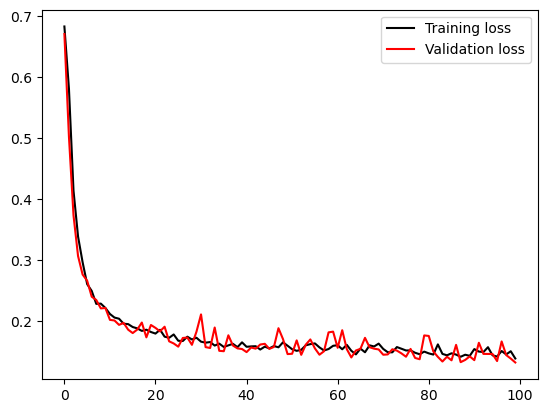

In [10]:
fig, ax = plt.subplots()

ax.plot(list(range(len(training_loss_list))), training_loss_list, color = 'black', label='Training loss')
ax.plot(list(range(len(validation_loss_list))), validation_loss_list,  color = 'red', label='Validation loss')
ax.legend()

To convert model outputs (i.e. a 2-dimensional vector of logits $\in \mathbb{R}^2$) into a classification result, we can select the class corresponding to the node with the higher value:

In [11]:
# Use the model in evaluation mode:
model.eval()

# Define a list of predictions:
list_label_prediction = []

# Iterates without computing gradients:
with torch.no_grad():
    # Make a prediction for each training/validation/test inputs:
    for i in range(len(full_df)):
        # Select the row/inputs for each index, convert to float32 tensor and move to the device
        row = full_df.iloc[i]
        x_range = row["x_range"]
        y_range = row["y_range"]
        xy_input =  torch.tensor([x_range, y_range], dtype=torch.float32)
        xy_input = xy_input.to(device)

        # Forward pass (model calls)
        logits_model = model(xy_input)

        # Select the highest value among possible logits
        predicted_class = torch.argmax(logits_model)

        # Append the prediction to the list:
        list_label_prediction.append(int(predicted_class.to('cpu')))

Define a dataframe and plot the predictions and GT. As expected, the predictions become blurred near the boundary and the whole set of OOD data (top right) is incorrectly labelled.

<Axes: xlabel='x_range', ylabel='y_range'>

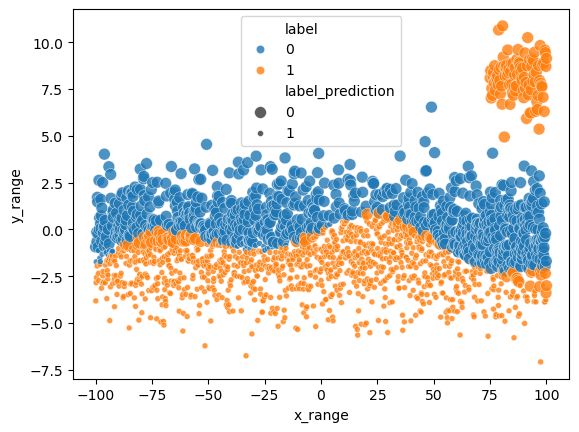

In [12]:
# Define an additional dataframe and add the previously calculated predictions
additional_df = full_df
additional_df['label_prediction'] = list_label_prediction 

# Scatter plot
sns.scatterplot(data=additional_df, x="x_range", y="y_range", hue="label", size = "label_prediction", alpha = 0.8)